In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM, Reshape, Activation
from keras.utils import  to_categorical
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from keras.optimizers import Adam

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


2024-09-14 21:05:52.733891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 21:05:52.734007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 21:05:52.869438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"


In [3]:
# Your existing code to load the dataset
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Changing integers to actual emotions.
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)

# Remove rows where 'Emotions' is 'calm'
Ravdess_df = Ravdess_df[Ravdess_df['Emotions'] != 'calm']

# Display the modified DataFrame
Ravdess_df.head()


,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()


,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


In [6]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()


,Emotions,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


In [7]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()


,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


In [9]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.plot(data)
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 4))
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram for audio with {} emotion'.format(e), size=15)
    plt.tight_layout()
    plt.show()



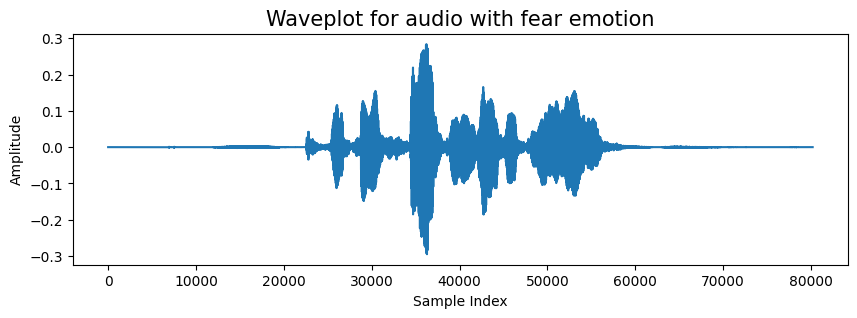

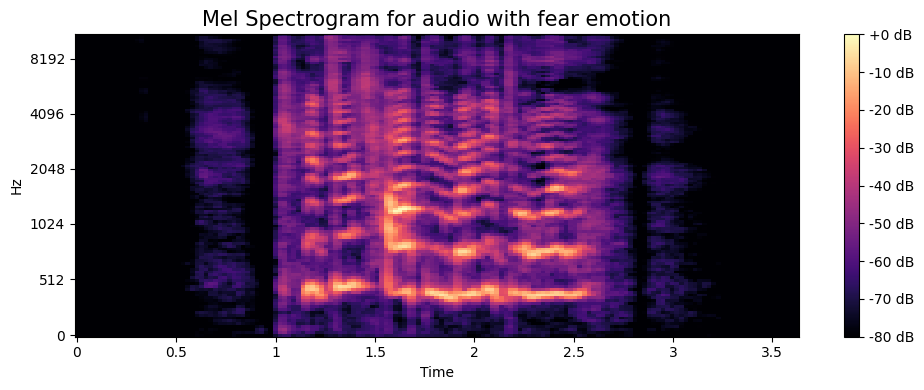

In [10]:
# Example usage
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


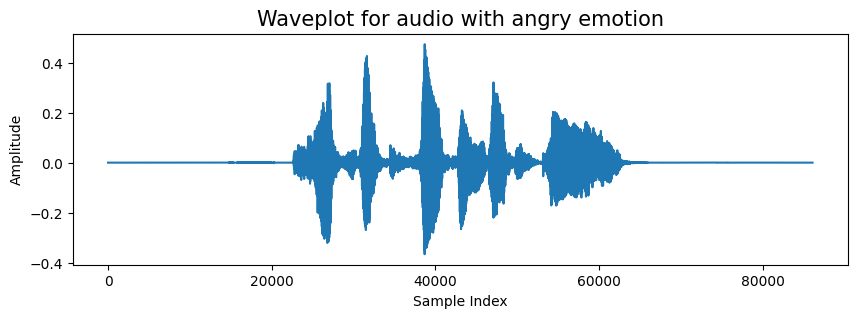

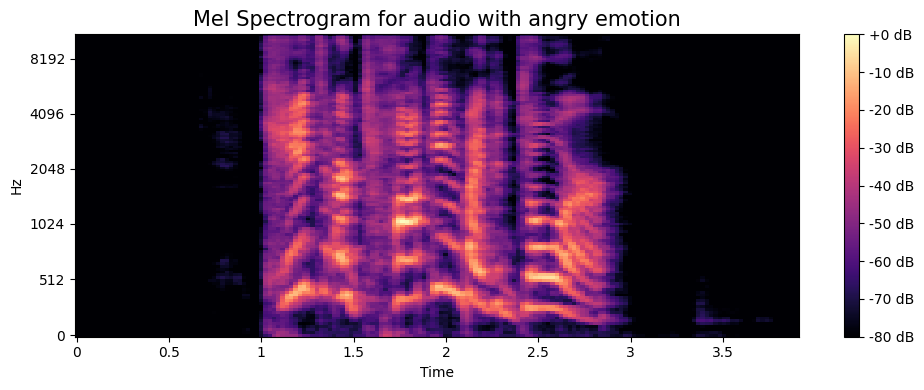

In [11]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


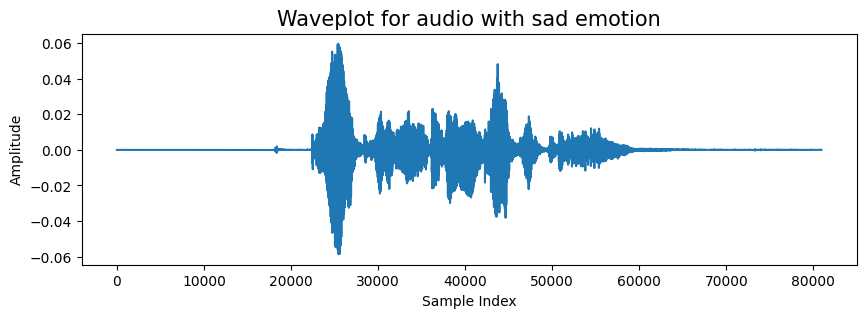

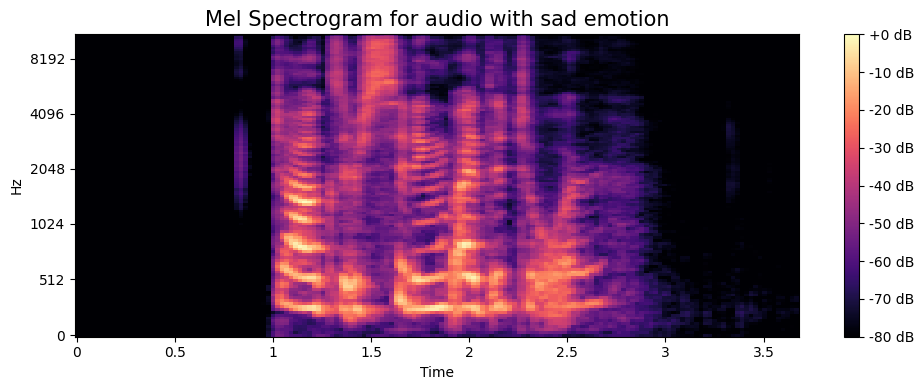

In [12]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


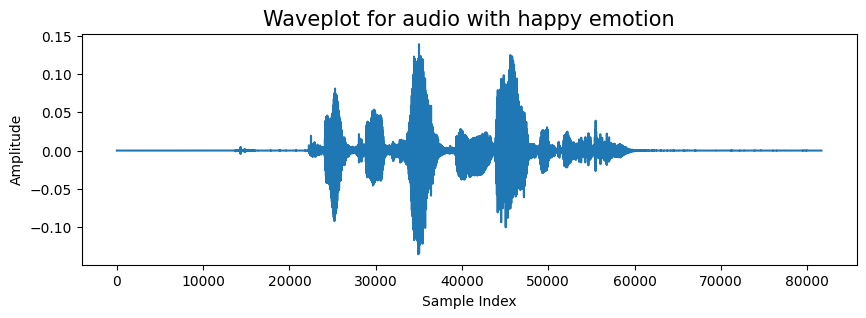

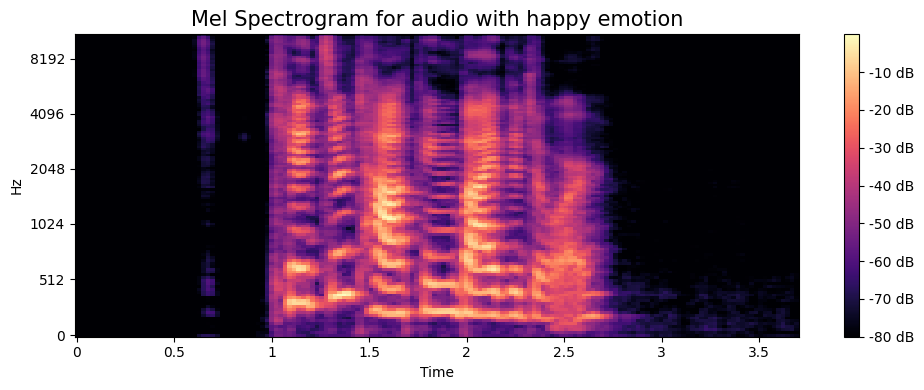

In [13]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)


In [15]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate) 
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    n_steps = int(pitch_factor * 12)  # Calculate the number of steps from pitch factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)  # Pass 'sr' and 'n_steps' as named arguments

# Load an example audio file
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)



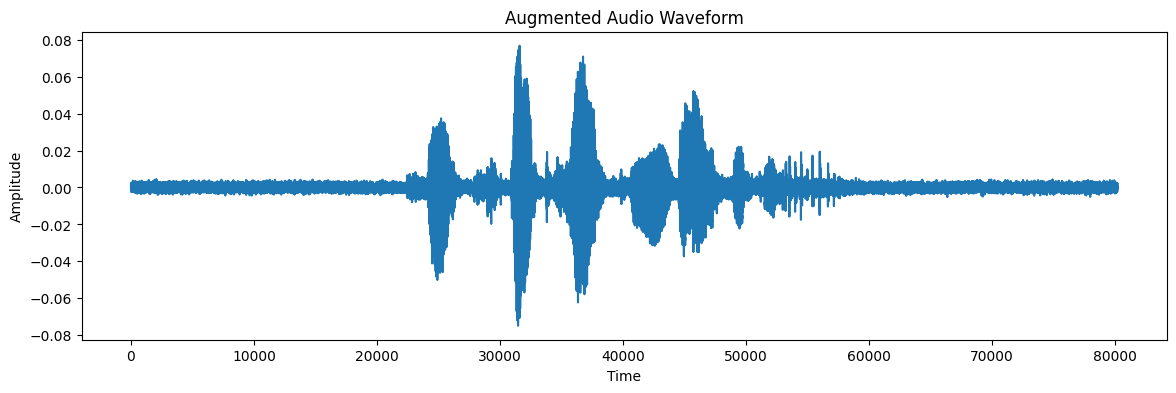

Augmented Audio:


In [16]:
augmented_data = noise(data)  # Example: Applying noise

# Create figure and subplots
plt.figure(figsize=(14, 4))

# Plot waveplot of augmented audio
plt.plot(augmented_data)
plt.title('Augmented Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Display the waveplot
plt.show()

# Listen to augmented audio
print("Augmented Audio:")
Audio(augmented_data, rate=sample_rate)


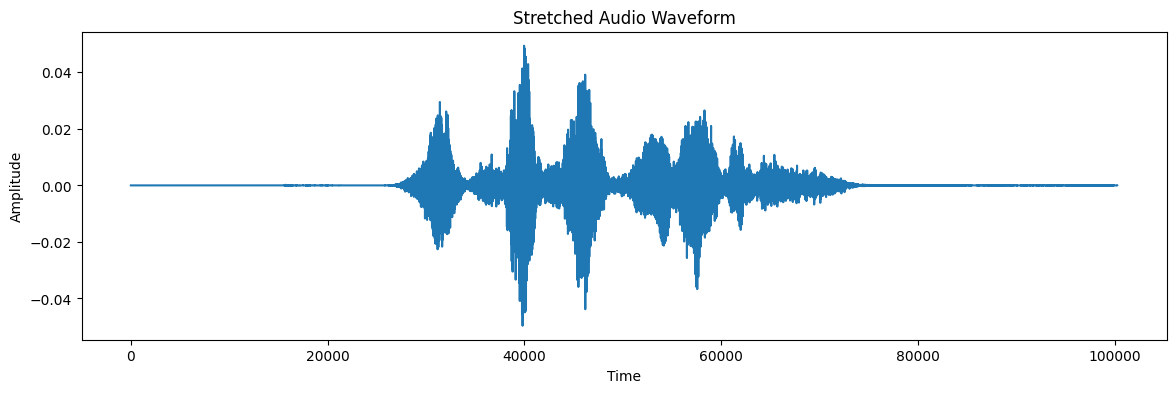

Stretched Audio:


In [17]:
stretched_data = stretch(data, 0.8)  

# Create figure and subplots
plt.figure(figsize=(14, 4))

# Plot waveplot of stretched audio
plt.plot(stretched_data)
plt.title('Stretched Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Display the waveplot
plt.show()

# Listen to stretched audio
print("Stretched Audio:")
Audio(stretched_data, rate=sample_rate)


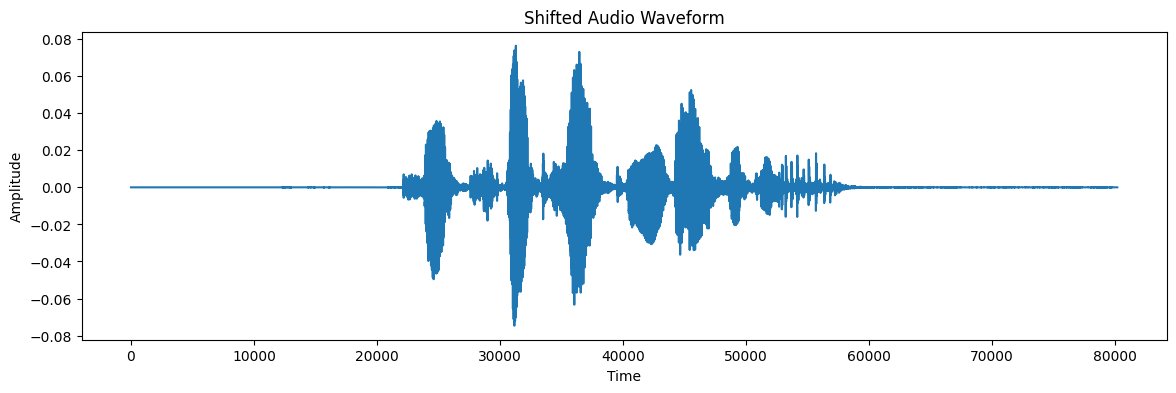

Shifted Audio:


In [18]:
shifted_data = shift(data)  
plt.figure(figsize=(14, 4))
plt.plot(shifted_data)
plt.title('Shifted Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Display the waveplot
plt.show()

# Listen to shifted audio
print("Shifted Audio:")
Audio(shifted_data, rate=sample_rate)


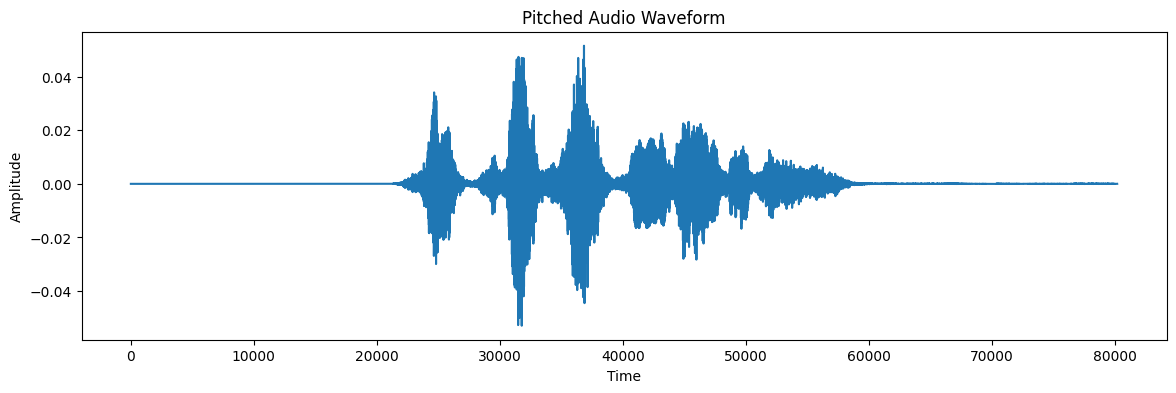

Pitched Audio:


In [19]:
pitched_data = pitch(data, sample_rate, pitch_factor=1.5)  # Applying pitch shift with a factor of 1.5

# Create figure and subplots
plt.figure(figsize=(14, 4))

# Plot waveplot of pitched audio
plt.plot(pitched_data)
plt.title('Pitched Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Display the waveplot
plt.show()

# Listen to pitched audio
print("Pitched Audio:")
Audio(pitched_data, rate=sample_rate)


In [20]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    shifted_data = shift(data)
    res4 = extract_features(shifted_data)
    result = np.vstack((result, res4))  # stacking vertically
    
    return result


In [21]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)


In [22]:
len(X), len(Y), data_path.Path.shape


(47880, 47880, (11970,))

In [23]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()


,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237382,0.682273,0.670519,0.614793,0.579039,0.566803,0.637206,0.667451,0.663883,0.669903,...,0.000234,0.000235,0.000138,0.000128,0.000299,0.000360,0.000275,0.000173,2.896729e-05,surprise
1,0.339251,0.743619,0.750691,0.725944,0.723084,0.750401,0.728725,0.718293,0.691123,0.706291,...,0.001777,0.001754,0.001632,0.001583,0.001763,0.001769,0.001767,0.001670,1.437347e-03,surprise
2,0.229695,0.524089,0.656546,0.681626,0.671707,0.670857,0.667543,0.689652,0.697089,0.644676,...,0.000173,0.000142,0.000122,0.000112,0.000071,0.000099,0.000083,0.000042,3.134385e-06,surprise
3,0.238516,0.686610,0.671062,0.615143,0.581009,0.579726,0.649866,0.676360,0.671000,0.679287,...,0.000234,0.000235,0.000138,0.000128,0.000299,0.000360,0.000275,0.000173,2.896725e-05,surprise
4,0.256113,0.621621,0.580278,0.598515,0.628296,0.598014,0.597272,0.650352,0.698635,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802854e-07,neutral


In [24]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


In [25]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [26]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((35910, 162), (35910, 7), (11970, 162), (11970, 7))

In [27]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((35910, 162), (35910, 7), (11970, 162), (11970, 7))

In [28]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((35910, 162, 1), (35910, 7), (11970, 162, 1), (11970, 7))

In [29]:
model = Sequential()

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=256, kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(units=512, kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(units=512, kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 64)           384       
                                                                 
 batch_normalization (Batch  (None, 162, 64)           256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 162, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 81, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 128)           4

In [30]:
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=1, patience=2, min_lr=0.0001)


In [31]:
history=model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/200


I0000 00:00:1726351965.497705     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 17s 13ms/step - loss: 1.8755 - accuracy: 0.3172 - val_loss: 1.6897 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 2/200
562/562 [==============================] - 7s 12ms/step - loss: 1.6039 - accuracy: 0.4251 - val_loss: 1.6915 - val_accuracy: 0.3591 - lr: 0.0010
Epoch 3/200
562/562 [==============================] - 7s 12ms/step - loss: 1.5074 - accuracy: 0.4625 - val_loss: 1.5519 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 4/200
562/562 [==============================] - 7s 12ms/step - loss: 1.4482 - accuracy: 0.4877 - val_loss: 1.4119 - val_accuracy: 0.4759 - lr: 0.0010
Epoch 5/200
562/562 [==============================] - 7s 12ms/step - loss: 1.4040 - accuracy: 0.5040 - val_loss: 1.3879 - val_accuracy: 0.5048 - lr: 0.0010
Epoch 6/200
562/562 [==============================] - 7s 12ms/step - loss: 1.3713 - accuracy: 0.5184 - val_loss: 1.4475 - val_accuracy: 0.4724 - lr: 0.0010
Epoch 7/200
562/562 [==============================] - 7s 12ms/step -

375/375 [==============================] - 1s 3ms/step - loss: 0.8056 - accuracy: 0.7404
Accuracy of our model on test data :  74.04344081878662 %


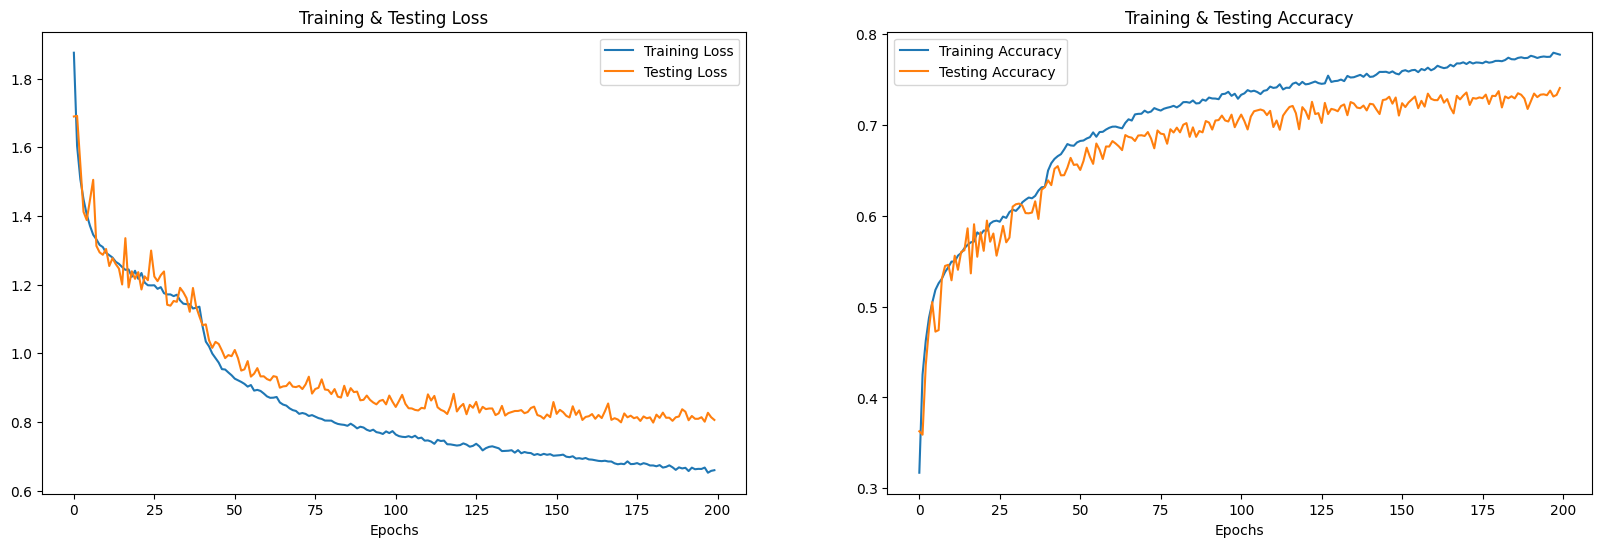

In [32]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()
